# Exercise 11: Dimensionality Reduction
In this exercise, we will implement and see the workings of a dimensionality reduction technique: Prinical Component Analysis (PCA).

In [1]:
# good to import few packages
# %matplotlib notebook
%matplotlib inline
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces

## 1. Toy Dataset
Let see the PCA results on a toy iris dataset.

In [2]:
# load iris dataset
iris = datasets.load_iris()
data = iris['data'].astype(np.float32) 
labels = iris['target'] 
cls_names = iris['target_names']

We will first visualize the trends of different features together. One can see that one class is well separated from the others.

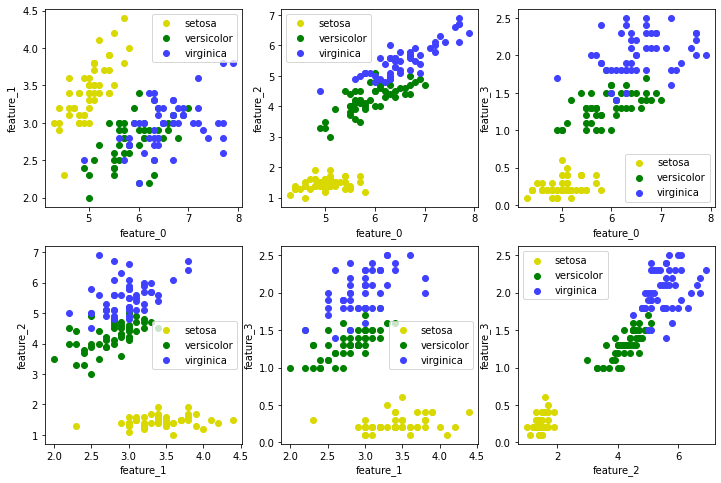

In [3]:
plt.figure(figsize=(12,8))
count = 1
colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])
for i in range(3):
    for j in range(i+1,4):
        plt.subplot(2,3,count)
        for ind,name in enumerate(cls_names):
            filtered_class = labels==ind
            plt.scatter(data[filtered_class,i],data[filtered_class,j],c=colors[ind,None],label=name)
        plt.xlabel(f'feature_{i}')
        plt.ylabel(f'feature_{j}')
        plt.legend()
        count +=1


## 2. PCA
In the Iris dataset, we have 4 features per data point. Let's now try to reduce the dimensionality from $D=4$ to $d=2$ using PCA. 
As seen in class, for a dataset $\mathbf{X}\in \mathbb{R}^{N\times D}$ and for a 1D projection ${\bf w}_{(1)}$, PCA solves the following optimization problem
   \begin{align}
    \underset{\mathbf{w}_{(1)}}{\operatorname{max}} \mathbf{w}_{(1)}^T\mathbf{C}\mathbf{w}_{(1)}\\
    s.t. ~~~~~ \mathbf{w}_{(1)}^T\mathbf{w}_{(1)} = 1
   \end{align}
   
 where $\mathbf{C}$ is the data covariance matrix
     \begin{align}
         \mathbf{C} &= \frac{1}{N}\sum_{i=0}^{N-1}(\mathbf{x}_i-\mathbf{\bar{x}})(\mathbf{x}_i-\mathbf{\bar{x}})^T\\
         \mathbf{\bar{x}} &= \frac{1}{N}\sum_{i=0}^{N-1} \mathbf{x}_i
     \end{align}
     
 and $\mathbf{w}_{(1)}\in \mathbb{R}^{D}$ is the projection vector we are looking for, $\mathbf{x}\in \mathbb{R}^{D\times 1}$ is one data sample, and $\mathbf{\bar{x}} = \tfrac{1}{N}\sum_{i=0}^{N-1}\mathbf{x}_i \in \mathbb{R}^{D\times 1}$ is the mean of the data.
 
 The solution to this problem consists in finding the eigenvector of data covariance matrix $\mathbf{C}$ with the largest eigenvalue. To project to $d>1$ dimensions, one take the $d(<D)$ eigenvectors with largest eigenvalues and aggregates them into a matrix $\mathbf{W} = [\mathbf{w}_{(1)}, \mathbf{w}_{(2)}, ..., \mathbf{w}_{(d)} ]$. Hence, $\mathbf{W}$ is a matrix of $d$ eigenvectors each being $D$-dimensional. 
 
Once $\mathbf{W}$ has been found, we can project our original data $\mathbf{X}\in \mathbb{R}^{N\times D}$ to $\mathbf{Y}\in \mathbb{R}^{N\times d}$, using the centered data $\tilde{\mathbf{X}}\in R^{N\times D}$,
    \begin{align}
        \mathbf{Y} &= \mathbf{\tilde{X}}\mathbf{W} \\
        \tilde{\mathbf{x}}_i &= \mathbf{x}_i-\mathbf{\bar{x}} ~~~~ \text{for } 0 \leq i \leq N-1
    \end{align}
 
Finally, to understand how much of the variance is explained by our $d$ eigenvectors, we compute the percentage of the variance explained as 
    \begin{align}
        \mathbf{exvar} = \frac{\sum_{i=0}^{d-1}\lambda_i}{\sum_{i=0}^{D-1}\lambda_i}
    \end{align}
where $\lambda_i$ is the ith largest eigenvalue. For different applications, one would like to choose $d$ such that the explained variance is greater than a threshold.

You are asked to code the ```PCA``` that implements the above procedure.

In [4]:
'''
Input:
    X: NxD matrix representing our data
    d: Number of principal components to be used to reduce dimensionality
    
Output:
    mean_data: 1xD representing the mean of the input data
    W: Dxd matrix representing the principal components
    eg: d values representing the variance corresponding to the principal components, ie. the eigenvalues
    Y: Nxd data projected in the principal components' direction
    exvar: explained variance by the principal components in percentage [%]
'''
def PCA(X, d):
    
    # Compute the mean of data
    mean = np.mean(X, 0)
    # Center the data with the mean
    X_tilde = X - mean
    # Create the covariance matrix
    C = X_tilde.T@X_tilde/X_tilde.shape[0]
    # Compute the eigenvectors and eigenvalues. Hint: use np.linalg.eigh
    eigvals, eigvecs = np.linalg.eigh(C)
    # Choose the top d eigenvalues and corresponding eigenvectors. Sort the eigenvalues( with corresponding eigenvectors )
    # in decreasing order first.
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:, ::-1]

    W = eigvecs[:, 0:d]
    eg = eigvals[0:d]

    # project the data using W
    Y = X_tilde@W
    
    # Compute the explained variance. Note: we want it in percentage
    exvar = 100*eg.sum()/eigvals.sum()

    return mean, W, eg, Y, exvar

Let's call the above function and visualize the projected data

In [5]:
d = 2
mean, W, eg, Y, exvar = PCA(data, d)
print(f'The total variance explained by the first {d} principal components is {exvar} %')

The total variance explained by the first 2 principal components is 97.76851402120015 %


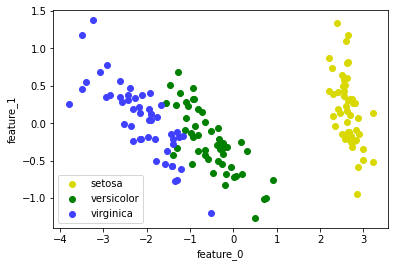

In [6]:
plt.figure()
for ind,name in enumerate(cls_names):
    filtered_class = labels==ind
    plt.scatter(Y[filtered_class,0], Y[filtered_class,1], c=colors[ind,None], label=name)
plt.xlabel(f'feature_0')
plt.ylabel(f'feature_1')
plt.legend()

**Q.** What happens when d=D?  
**A.** There is no loss of information, but the data is projected to uncorrelated axes.

**Q.** What happens when D>>N?  
**A.** Most of the eigenvalues will be zero and additionally, since the computation complexity is ~$O(D^3)$, the current implementation will be slow. For more explanations see Bishop on pages 569-570.

## 3. EigenFaces
Now, we will use PCA on images of faces. The goal is to represent faces in the dataset as a linear combination of so-called *eigenfaces*, ie. eigenvectors of this dataset of faces.

In [7]:
faces = fetch_olivetti_faces().data
print(f'Dimensions of the Face dataset: N={faces.shape[0]}, D={faces.shape[1]}')

Dimensions of the Face dataset: N=400, D=4096


Run PCA on this dataset, and try different values of $d$ to see the impact on the explained variance.

In [8]:
d = 30
mean, W, eg, Y, exvar = PCA(faces, d)
print(f'The total variance explained by the first {d} principal components is {exvar} %')

The total variance explained by the first 30 principal components is 81.78947897573916 %


### 3.1 Visualize
Let us see what the mean face and the principal components look like.

Text(0.5, 1.0, 'Mean Face')

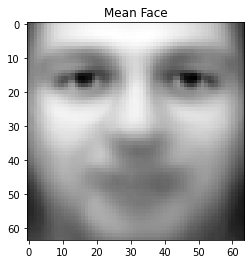

In [9]:
plt.figure()
plt.imshow(mean.reshape(64,64), cmap='gray')
plt.title('Mean Face')

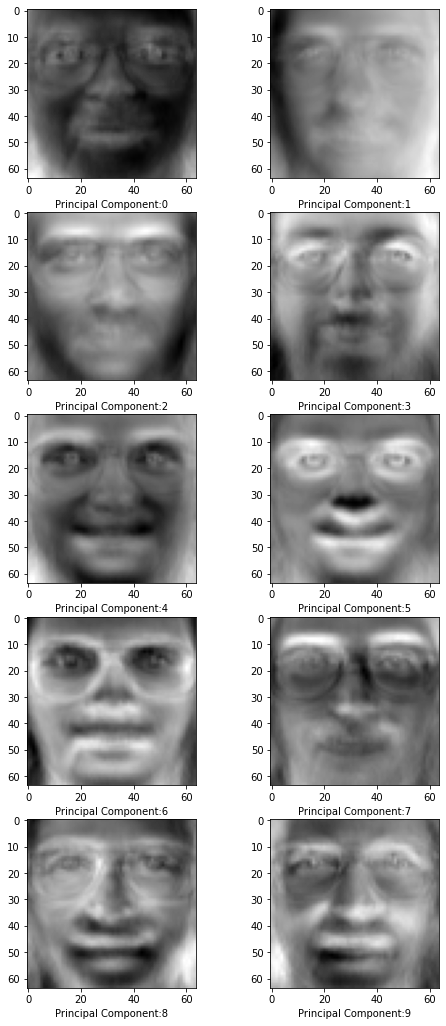

In [10]:
# Visualize the first 10 principal components
plt.figure(figsize=(8,18))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(W.reshape(64,64,-1)[...,i], cmap='gray')
    plt.xlabel(f'Principal Component:{i}')

Observe what these components account for. Vary the slider to change the principal component id and its influence on the mean value. 

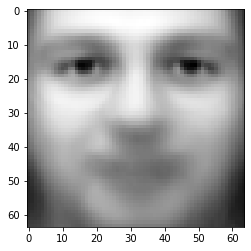

interactive(children=(IntSlider(value=0, description='pcind', max=29), IntSlider(value=0, description='pcweigh…

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.imshow(mean.reshape(64,64),cmap='gray')

def update(pcind = 0,pcweight=0):
    img = W.copy()[:,pcind]*pcweight
    line.set_data((img+mean).reshape(64,64))
    fig.canvas.draw_idle()

interact(update,pcind=(0,d-1,1),pcweight=(-10,10,1));

**Q.** Can you identify what component accounts for what?  
**A.** The first two components account for the illumination, the third changes the face width, and others, such as the 12th(0-indexed), vary from a smiling to a neutral face. 


### 3.2 Reconstruction
We can now project one original data sample $\mathbf{x}_i \in \mathbb{R}^{D}$ to a lower-dimensional representation $\mathbf{y}_i  \in \mathbb{R}^{d} $ using $\mathbf{W} \in \mathbb{R}^{D\times d}$ using the following operation: $$\mathbf{y}_i = \mathbf{W}^T (\mathbf{x}_i - \bar{\mathbf{x}})$$

From this compressed representation $\mathbf{y}_i$, we can recover an approximation of the original data $\hat{\mathbf{x}}_i \in \mathbb{R}^{D}$ by using the opposite projection:
$$\hat{\mathbf{x}}_i = \bar{\mathbf{x}} + \mathbf{W}\mathbf{y}_i$$


Depending on how many dimension $d$ are kept, we will have some loss of information. Here we will see how changing $d$ affects the reconstruction $\hat{\mathbf{x}}_i$.

In [12]:
# Try different values of d
d = 10
mean, W, eg, Y, exvar = PCA(faces, d)
print(f'The total variance explained by the first {d} principal components is {exvar} %')

The total variance explained by the first 10 principal components is 65.63390350571912 %


In [13]:
# Here we first select a random face from the dataset
sample_id = np.random.choice(faces.shape[0],1)[0]
sample_face = faces[sample_id,:]
# TODO: project this face to its smaller dimension representation
proj_face = W.T@(sample_face-mean)          # TO BE DONE BY STUDENTS
# TODO: undo the projection (by applying W.T), to recover 
# an approximation of the initial face, from proj_face
reconstructed_face = mean + W@proj_face # TO BE DONE BY STUDENTS

Text(0.5, 1.0, 'Reconstructed Image')

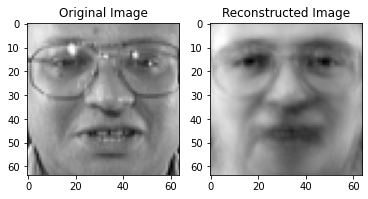

In [14]:
# We now visualize the original face, and the one reconstructed from
# the projection on the d first eigen vectors
plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(sample_face.reshape(64,64),cmap='gray')
ax.set_title('Original Image')
ax = plt.subplot(1,2,2)
plt.imshow(reconstructed_face.reshape(64,64),cmap='gray')
ax.set_title('Reconstructed Image')